# 1. SETTINGS

In [281]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from IPython.display import display
import scipy.stats

In [282]:
# pandas options
pd.set_option("display.max_columns", None)

In [283]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [284]:
# garbage collection
import gc
gc.enable()

# 2. NAIVE BENCHMARK

In [285]:
# import data
train = pd.read_csv("../data/prepared/train.csv")
test  = pd.read_csv("../data/prepared/test.csv")

In [286]:
# check all datasets
display(test.head(3))
print("Test data:", test.shape)
print("------------------------------")
display(train.head(3))
print("Train data:", train.shape)

,PredictionIdx,DateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,WeekLag
0,a1e0d80784,20180423,1856,13323,Buy,NaN,0
1,c2cc6cc2a8,20180423,1856,9230,Buy,NaN,0
2,a8e94f6344,20180423,1780,9157,Buy,NaN,0


Test data: (484758, 7)
------------------------------


,WeekLag,CustomerIdx,IsinIdx,BuySell,CustomerInterest
0,1.0,0,27045,Buy,1
1,1.0,0,27298,Sell,1
2,1.0,5,10842,Buy,1


Train data: (6262730, 5)


In [287]:
# recompute week index
train["WeekLag"] = train["WeekLag"].max() - train["WeekLag"]

In [288]:
# aggregate
train = train.groupby(["CustomerIdx", "WeekLag", "IsinIdx", "BuySell"], as_index = False).max()

In [289]:
# compute lags
for t in range(1, 51):
    train["Lag" + str(t)] = train.groupby(["CustomerIdx", "IsinIdx", "BuySell"], as_index = False).CustomerInterest.shift(t).fillna(0)

In [290]:
# data partitioning
valid = train[train["WeekLag"]   > 115]
train = train[(train["WeekLag"] <= 115) & (train["WeekLag"] > 50)]

In [291]:
### function for historical target ratio
def compute_target(data, lags):
    
    # filter lags
    feats = ["Lag" + str(i) for i in range(1, lags + 1)]
    data["Last" + str(lags) + "Weeks"] = data[feats].max(axis = 1)
    
    # return test data
    return data

In [300]:
train = compute_target(train, lags = 2)
train = compute_target(train, lags = 4)
train = compute_target(train, lags = 8)
train = compute_target(train, lags = 12)
train = compute_target(train, lags = 16)
train = compute_target(train, lags = 20)
train = compute_target(train, lags = 24)
train = compute_target(train, lags = 28)
train = compute_target(train, lags = 32)
train = compute_target(train, lags = 36)
train = compute_target(train, lags = 42)
train = compute_target(train, lags = 46)

valid = compute_target(valid, lags = 2)
valid = compute_target(valid, lags = 4)
valid = compute_target(valid, lags = 8)
valid = compute_target(valid, lags = 12)
valid = compute_target(valid, lags = 16)
valid = compute_target(valid, lags = 20)
valid = compute_target(valid, lags = 24)
valid = compute_target(valid, lags = 28)
valid = compute_target(valid, lags = 32)
valid = compute_target(valid, lags = 36)
valid = compute_target(valid, lags = 42)
valid = compute_target(valid, lags = 46)

In [301]:
# list of features
features = train.filter(like = "Last").columns
features

Index(['Last2Weeks', 'Last4Weeks', 'Last8Weeks', 'Last16Weeks', 'Last32Weeks',
       'Last12Weeks', 'Last20Weeks', 'Last24Weeks', 'Last28Weeks',
       'Last36Weeks', 'Last42Weeks', 'Last46Weeks'],
      dtype='object')

In [311]:
### PARAMETERS

# learner settings
metric   = "auc"
verbose  = 10
stopping = 100
seed = 42

# lgb settings
gbm = lgb.LGBMClassifier(n_estimators     = 1000,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_lambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = seed)

In [312]:
# train lightGBM
gbm = gbm.fit(train[features], y_train, 
              eval_set = [(train[features], y_train), (valid[features], y_valid)], 
              eval_metric = metric, 
              verbose = verbose, 
              early_stopping_rounds = stopping)
    
# save number of iterations
num_iters = gbm.best_iteration_

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.630993	valid_1's auc: 0.643572
[20]	valid_0's auc: 0.630993	valid_1's auc: 0.643572
[30]	valid_0's auc: 0.630993	valid_1's auc: 0.643572
[40]	valid_0's auc: 0.630993	valid_1's auc: 0.643572
[50]	valid_0's auc: 0.630993	valid_1's auc: 0.643572
[60]	valid_0's auc: 0.630993	valid_1's auc: 0.643572
[70]	valid_0's auc: 0.630993	valid_1's auc: 0.643572
[80]	valid_0's auc: 0.630993	valid_1's auc: 0.643572
[90]	valid_0's auc: 0.630993	valid_1's auc: 0.643572
[100]	valid_0's auc: 0.630993	valid_1's auc: 0.643572
Early stopping, best iteration is:
[2]	valid_0's auc: 0.630993	valid_1's auc: 0.643572


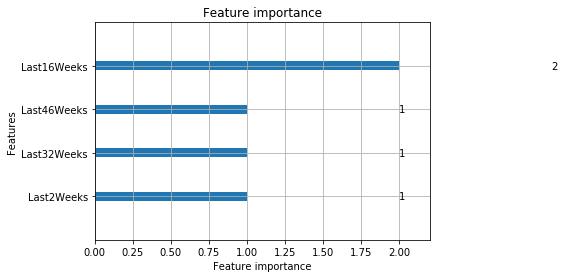

In [313]:
ax = lgb.plot_importance(gbm, max_num_features=None)
plt.show()

In [61]:
# export CSV
subm = test[["PredictionIdx", "CustomerInterest"]]
subm.to_csv("../submissions/naive_6week_ratios.csv", index = False, float_format = "%.8f")

In [120]:
### function for historical target ratio
def compute_target_ratio(train, test, lags):
    
    # filter lags
    tmp = train[train["WeekLag"] <= lags]
    del tmp["WeekLag"]
    
    # aggregating
    tmp = tmp.groupby(["CustomerIdx", "IsinIdx", "BuySell"], as_index = False).mean()
    tmp.columns = ["CustomerIdx", "IsinIdx", "BuySell", "ratio" + str(lags)]
    
    # merge to test
    test = test.merge(tmp, how = "left", on = ["CustomerIdx", "IsinIdx", "BuySell"])
    
    # fill NA with zeros
    test["ratio" + str(lags)].fillna(0, inplace = True)
    
    # return test data
    return test

In [121]:
# compute ratios
valid = compute_target_ratio(train, valid, lags = 5+4)
valid = compute_target_ratio(train, valid, lags = 5+8)
valid = compute_target_ratio(train, valid, lags = 5+16)
valid = compute_target_ratio(train, valid, lags = 5+32)
valid = compute_target_ratio(train, valid, lags = 5+64)
valid = compute_target_ratio(train, valid, lags = 5+128)

In [228]:
# extract target
y_train = train["CustomerInterest"]
y_valid = valid["CustomerInterest"]

In [101]:
# average all ratios
test.CustomerInterestPred = test.filter(like = "ratio").mean(axis = 1)

In [102]:
roc_auc_score(test.CustomerInterest, test.CustomerInterestPred)

0.6816434726205932